In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General
import numpy as np
import pickle as pk
import math

# For optimization
import pygmo as pg

# For computing acceleration and potential
import polyhedral_gravity as model

# For working with the mesh
import mesh_utility
import tetgen
import meshio as mio

# For Plotting
import pyvista as pv
import mesh_plotting
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm


class basic_udp:
    
    def __init__(self):
        # Creating the mesh (TetGen)
        self.mesh, self.vertices, self.faces = mesh_utility.create_mesh()
        # Defining additional parameters
        self.density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
        self.sq_target_altitude = 5000**2    # In unit: [m]
        self.t_end = 20*3600.0              # Final time
        self.t_0 = 0                 # Starting time
        self.d_t = 800.0                 # Number of steps along orbit 
    
    def fitness(self,x):
        fit_val, r_store, v_store = self.compute_trajectory(x)
        return [fit_val]

    def get_bounds(self):
        # Bounds for the initial domain (i.e bounds for possible x-chromosomes)
        #   min=[r_x,r_y,r_z,v_x,v_y,v_z], max=[r_x,r_y,r_z,v_x,v_y,v_z]
        # Good starting boundaries could e.g be right outside the most protruding part of the the mesh 
        return ([-6000,-6000,-6000,0,0,0],[6000,6000,6000,2.5,2.5,2.5])

    def compute_trajectory(self, x):

        # Initial information
        r = np.transpose(x[0:3]) # Start Position
        v = np.transpose(x[3:6]) # Initial velocity

        # Array containing times for summation
        time_list = np.arange(self.t_0, self.t_end, self.d_t)

        # Fitness value (to be maximized)
        fit_val = 0

        # Numpy Arrays to store trajectory information
        r_store = np.zeros((3,len(time_list)))
        v_store = np.zeros((3,len(time_list)))

        # Add starting position to memory
        r_store[:,0] = r
        v_store[:,0] = v

        for i in range(1,len(time_list)):
            # Retrieve information at current position
            altitude = self.compute_altitude(r)
            potential, a, tensor = model.evaluate(self.vertices, self.faces, self.density, r)
            a = - np.array(a)

            # Computing velocity and position for next time-step
            v_n = v + self.d_t * a
            r_n = r + self.d_t * v

            # Evaluate current position
            # fit_val += abs(self.sq_target_altitude - altitude)

            # Update current velocity and position
            v = v_n
            r = r_n

            # Storing updated trajectory information
            r_store[:,i] = r
            v_store[:,i] = v
            i += 1

        sq_altitudes = r_store[0,:]**2 + r_store[1,:]**2 + r_store[2,:]**2
        fit_val = np.mean(np.abs(sq_altitudes - self.sq_target_altitude))
        return fit_val, r_store, v_store


    def compute_altitude(self, r):
        # Obtaining closest distance from mesh to satelite: 
        #    See PyVista function: https://docs.pyvista.org/api/core/_autosummary/pyvista.DataSet.find_closest_point.html
        #index = self.mesh.grid.find_closest_point(r) 
        #closest_point = self.mesh.grid.points[index]
        #altitude = np.linalg.norm(closest_point-r)
        # altitude = np.linalg.norm(r)
        altitude = np.dot(r,r)
        return altitude


    def plot_trajectory(self, r_store):

        # Plotting mesh of asteroid/comet
        mesh_plot = pv.Plotter()
        mesh_plot.add_mesh(self.mesh.grid, show_edges=True)
        mesh_plot.show_bounds(grid='front',location='outer',all_edges=True)

        # Plotting trajectory
        trajectory_plot = pv.PolyData(np.transpose(r_store))
        mesh_plot.add_mesh(trajectory_plot, color=[0.6, 0.2, 0.1], style='surface')
        trajectory_plot = pv.PolyData(np.transpose(r_store[:,-1]))
        mesh_plot.add_mesh(trajectory_plot, color=[1.0, 1.0, 1.0], style='surface')
        
        mesh_plot.show(jupyter_backend='panel')

In [3]:
udp = basic_udp()

In [4]:
# Defining problem
prob = pg.problem(udp)
print(prob)

Problem name: <class '__main__.basic_udp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-6000, -6000, -6000, 0, 0, ... ]
	Upper bounds: [6000, 6000, 6000, 2.5, 2.5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [5]:
# Defining algorithm
algo = pg.algorithm(pg.sade(gen = 32))
pop = pg.population(prob = prob, size = 10)

In [6]:
# Optimization
algo.set_verbosity(1)
pop = algo.evolve(pop)


   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    2.60663e+09       0.556643       0.330553        15988.9    1.59042e+10
      2             20    2.17853e+09       0.284559       0.330553        13704.5    1.57207e+10
      3             30    2.09949e+09       0.284559       0.330553        15819.8    1.57998e+10
      4             40    2.09949e+09       0.284559       0.330553        15819.8    1.57998e+10
      5             50    2.09949e+09       0.284559       0.330553        15818.8    1.07792e+10
      6             60    2.09949e+09       0.284559       0.330553        15818.8    1.07792e+10
      7             70    1.70935e+09       0.504307       0.793599        11219.7    1.10665e+10
      8             80    1.35846e+09       0.504307       0.793599        15224.1    1.12383e+10
      9             90    1.35846e+09       0.504307       0.793599        15224.1    1.12383e+10
     10            

In [7]:
# Logs for output
uda = algo.extract(pg.de)
#uda.get_log() 
print("Champion fitness value: ", pop.champion_f) 
print("Champion chromosome: ", pop.champion_x) 

Champion fitness value:  [15387713.95801845]
Champion chromosome:  [ 6.12445798e+02 -1.85341979e+03 -3.21697982e+02  5.96852807e-01
  2.81288311e-01  6.81229570e-01]


/Users/rasmus/opt/anaconda3/envs/67P_Swarm/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  warnings.warn(


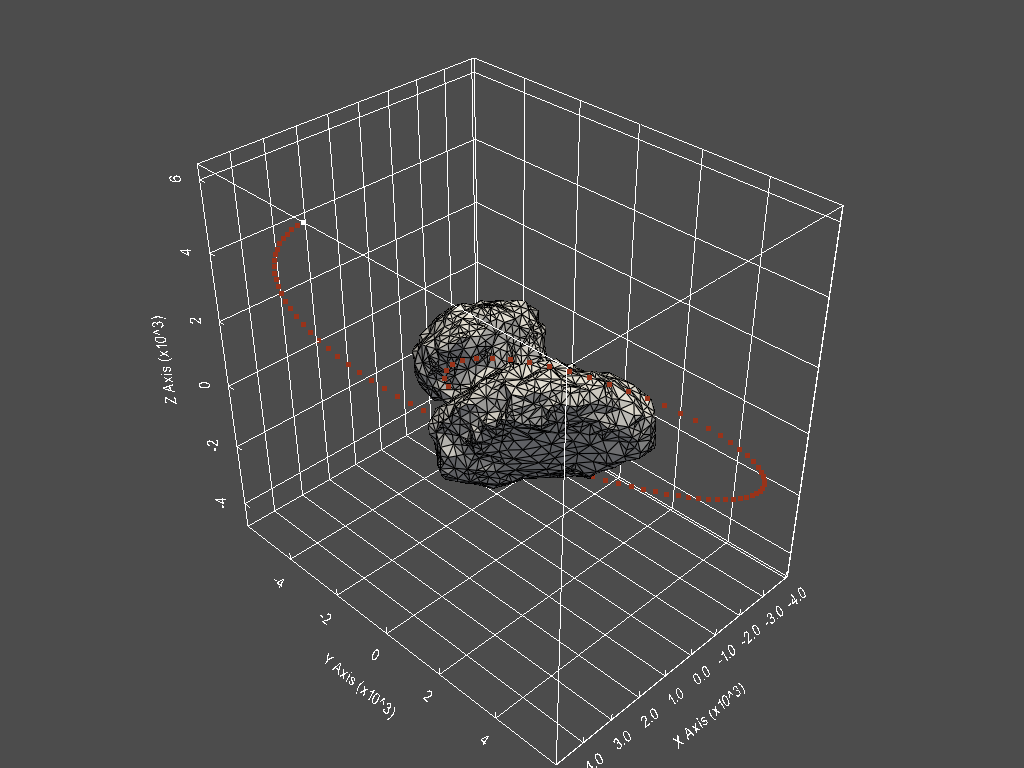

In [8]:
# Retrieving champion chromosome
x = pop.champion_x

# Computing optimized trajectory
fit_val, r_store, v_store = udp.compute_trajectory(x)

# Plotting trajectory
udp.plot_trajectory(r_store)

In [ ]:
plt.plot(r_store[1],r_store[2])